# Tutorial2: PyTorch basics

## Outline

- Datasets
- Models
- Losses
- Optimizers

Official resources:
* [Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

Here no details, mostly visualization, with linear regression.

### Imports

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

## Datasets

### A raw dataset

The data are obtained from the model 
$$
x \mapsto y:=Ax + b
$$
with $x\in\mathbb R^{input\_dim}$ and $y\in\mathbb R^{output\_dim}$.

In [4]:
# Linear regression model
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) - 1  # Random weights
b = 2 * np.random.rand(output_dim) - 1  # Random bias

true_model = lambda x: A @ x + b

We get a training set by randomly sampling and noisy observations
\begin{align*}
&x_i \sim U([-1, 1])\\
&y_i = A x_i + b + \nu_i
\end{align*}

In [5]:
n_train = 1000
noise_level = 0.04

# Generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)  # shape = (1000, 1)
y_train = np.array([true_model(x) for x in X_train])  # shape = (1000, 1)

# Add some noise
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

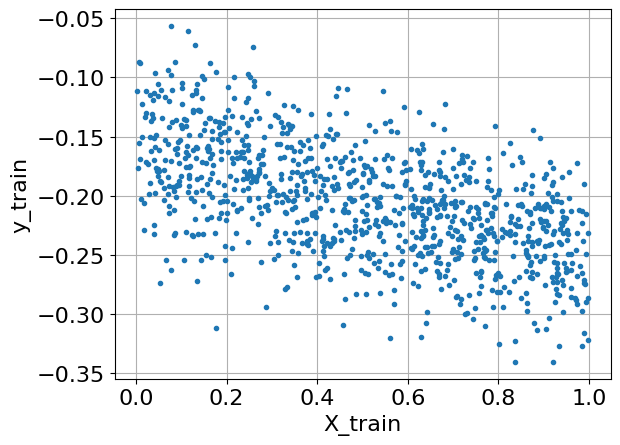

In [6]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

### PyTorch `Dataset`

In [8]:
#%% Dataset to manage vector to vector data
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))  # Convert to float tensor 
        self.output_data = torch.tensor(output_data.astype('f'))  # f is short for np.float32
        
    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], 
                  self.output_data[idx, :])  
        return sample 

In [9]:
training_set = VectorialDataset(input_data=X_train, output_data=y_train)
len(training_set)

1000

In [12]:
training_set[10:13]  # tuple of X[10:13] and y[10:13]

(tensor([[0.4620],
         [0.6462],
         [0.4788]]),
 tensor([[-0.2066],
         [-0.1926],
         [-0.1784]]))

Here almost useless, but think about e.g. images.

### PyTorch `DataLoader`

In [13]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(
    training_set, 
    batch_size=batch_size, 
    shuffle=True
    # shuffle is particularly important for stochastic gradient descent
    # to make sure you are not learning a specifc part of the graph each batch.
)

The role of `batch_size`:

In [15]:
for idx, batch in enumerate(train_loader):
    print(f'Batch n. {idx+1:2d}: input size={batch[0].shape}, output size={batch[1].shape}')

Batch n.  1: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  2: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  3: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  4: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  5: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  6: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  7: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  8: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  9: input size=torch.Size([40, 1]), output size=torch.Size([40, 1])


In [16]:
(8 * 120) + 40

1000

The role of `shuffle`:

In [13]:
first_batch = []

for epoch in range(2):
    for idx, batch in enumerate(train_loader):
        if idx == 0:
            first_batch.append(batch)

# numpy concatenation to visualize the first batch     
np.c_[X_train[:batch_size], first_batch[0][0].numpy(), first_batch[1][0].numpy()]

array([[2.05784788e-01, 4.36037987e-01, 6.01623714e-01],
       [7.19817837e-01, 7.86145389e-01, 6.72215939e-01],
       [6.09538035e-01, 7.84872293e-01, 7.33218729e-01],
       [8.82615981e-01, 3.95612359e-01, 5.57048738e-01],
       [3.43085796e-03, 1.70190156e-01, 7.24182546e-01],
       [8.30641732e-02, 9.18918371e-01, 9.32161152e-01],
       [6.35257739e-01, 4.30486172e-01, 6.49381876e-01],
       [1.75627838e-01, 4.74885613e-01, 8.14921916e-01],
       [1.82322421e-01, 6.92526758e-01, 8.47791076e-01],
       [9.80213257e-01, 8.58902335e-01, 5.85259080e-01],
       [2.10579174e-01, 4.70532626e-01, 6.51153088e-01],
       [1.98352101e-01, 6.09538019e-01, 3.83458883e-01],
       [1.54870878e-01, 6.58187032e-01, 7.16468036e-01],
       [9.86925902e-02, 2.18983032e-02, 6.72925487e-02],
       [2.76020335e-03, 1.91518009e-01, 9.92547750e-01],
       [1.96776921e-01, 1.47700906e-01, 9.34993684e-01],
       [8.41014066e-01, 9.04534996e-01, 3.88683110e-01],
       [8.38633120e-01, 8.67086

## Models

We implement a linear model $$x \mapsto model(x):=A x + b$$ 

with $A\in \mathbb{R}^{input\_dim\times output\_dim}$, $b\in\mathbb{R}^{output\_dim}$.

In [17]:
import torch.nn as nn
import torch

#%% Linear layer
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out
    
    def reset(self):
        self.linear.reset_parameters()

In [18]:
model = LinearModel(input_dim, output_dim)

### Model inspection

In [19]:
print(model)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


See [pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html) for many other layers.

In [23]:
list(model.parameters())
# print initial weights (matrix A) and biases (vector b)

[Parameter containing:
 tensor([[-0.5017]], requires_grad=True),
 Parameter containing:
 tensor([-0.5464], requires_grad=True)]

In [21]:
model.linear.weight

Parameter containing:
tensor([[-0.5017]], requires_grad=True)

In [22]:
model.linear.bias

Parameter containing:
tensor([-0.5464], requires_grad=True)

### The `forward` method

In [25]:
x = torch.randn(5, input_dim)
model.forward(x)
# Single forward pass with random input

tensor([[-0.4471],
        [-0.7359],
        [-0.1304],
        [-0.4204],
        [ 0.2291]], grad_fn=<AddmmBackward0>)

In [26]:
[model.linear.weight @ xx + model.linear.bias for xx in x] 
# Ax + b for each sample in x
# Manual implementation of the forward pass above

[tensor([-0.4471], grad_fn=<AddBackward0>),
 tensor([-0.7359], grad_fn=<AddBackward0>),
 tensor([-0.1304], grad_fn=<AddBackward0>),
 tensor([-0.4204], grad_fn=<AddBackward0>),
 tensor([0.2291], grad_fn=<AddBackward0>)]

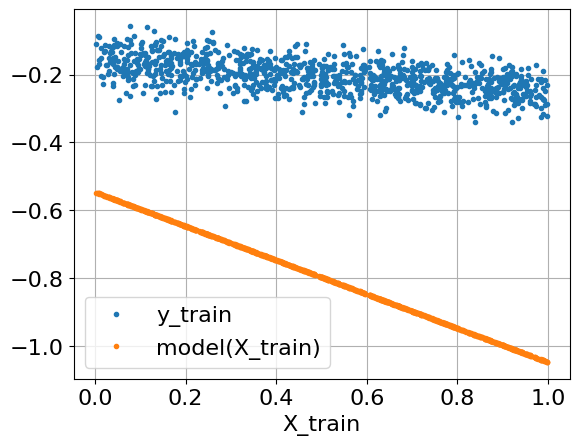

In [ ]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)'])   

# No training done yet, so the model is not fitted to the data 

## Losses

### The MSE loss

The MSE loss is
$$
L(y, y') = \|y-y'\|_2^2
$$

In [29]:
import torch.nn as nn
loss_fun = nn.MSELoss(reduction='mean')

More at [pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [31]:
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)
# MSE = 1/3 * ((1-0)^2 + (2-0)^2 + (1-0)^2) 
# MSE = 1/3 * (1 + 4 + 1) 
# MSE = 2

tensor(2.)

### Giving a score to the model (parameters) given the training set

The loss for one data pair $(x_i, y_i)$ is 
$$
L(model(x_i), y_i)
$$

The cumulative (average) loss on the training set is 
$$
L(X_{train}, y_{train}):=\frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(model(x_i), y_i)
$$

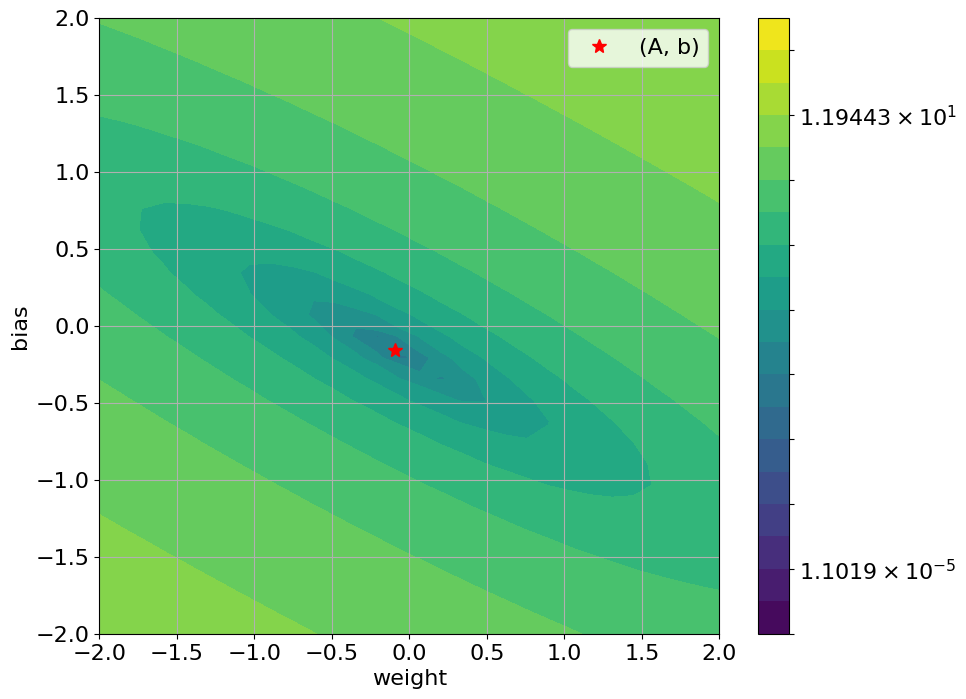

In [ ]:
if input_dim == output_dim == 1:

    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))
    # create a grid of weights and biases
    # visualise the loss at each point in the grid

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(A, b)'])
    
    ax.grid(True)    

## Optimization

Goal: minimize the loss given the data:
$$
\min\limits_{par \in model} L(X_{train}, y_{train})
=\min\limits_{par \in model} \frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(x_i, model(x_i))
$$

In this case $par =\{A, b\}$.

Iterative gradient based optimization for parameters, $par^{(k)}$:
\begin{align*}
par^{(0)} &= par_0\\
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X_{train}, y_{train})
\end{align*}    
with learning rate $\eta^{(k)}$.

### Gradients

The model is 
$$
model(x) = A x + b
$$

With $input\_dim = output\_dim = 1$ we have $A:=a\in\mathbb{R},\ b\in\mathbb{R}$. 

For a data pair $(x, y)$ the loss is
\begin{align*}
L(x, y) 
&= \|model(x)-y\|_2^2\\ 
&= (model(x)-y)^2\\
&= (a x + b - y)^2\\
&= a^2 x^2 + 2 a b x - 2 a xy + b^2 -2 b y + y^2.
\end{align*}

We can compute the partial differentials
\begin{align*}
\nabla_a L(x, y) 
&= 2 a x^2 + 2 b x - 2 xy
=2 x (a x + b - y)\\
\nabla_b L(x, y)
&= 2 a x + 2 b - 2 y
= 2 (ax + b - y).
\end{align*}


In [33]:
x = torch.randn(1, input_dim)
y =  torch.randn(1, output_dim)

# Calculate the inital gradients
model.zero_grad()
loss = loss_fun(model.forward(x),  y)
loss.backward()  # Compute gradients

In [34]:
if input_dim == output_dim == 1:
    print(model.linear.weight.grad)  # partial derivative of the loss w.r.t. the weight
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))
    
    print(model.linear.bias.grad)  # partial derivative of the loss w.r.t. the bias
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[1.7618]])
tensor([[1.7618]], grad_fn=<MulBackward0>)
tensor([9.4728])
tensor([[9.4728]], grad_fn=<MulBackward0>)


### Handmade optimization

In [36]:
if input_dim == output_dim == 1:

    num_iter = 200
    lr = 0.5 # learning rate

    train_hist = {}  # dictionary of training history
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        # Get current weights and biases
        w = model.linear.weight.item()
        b = model.linear.bias.item()

        # Gradients
        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        # Update weights and biases
        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

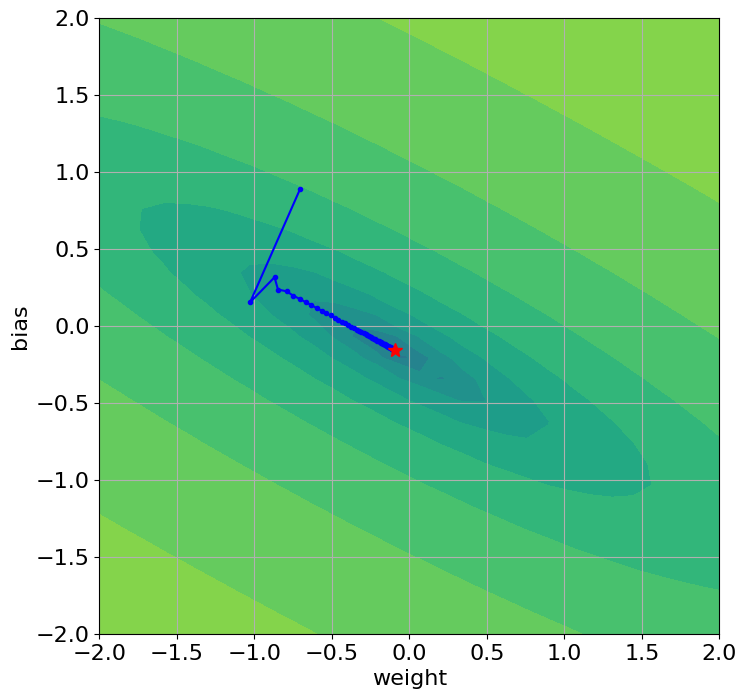

In [37]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    #ax.legend(['optim', '(A, b)'])

### Stochastic GD

* Avoid loading the full training set
* Avoid evaluating the model on the full training set

At every step, compute the loss on a batch of data $(X^{(k)}, y^{(k)})\sim (X_{train}, y_{train})$: 

\begin{align*}
L(X^{(k)}, y^{(k)}) := \sum_{(x, y) \in (X^{(k)}, y^{(k)})} L(x, model(x)).
\end{align*}    

and then update with this approximated gradient:
\begin{align*}
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X^{(k)}, y^{(k)}). 
\end{align*}    

In [ ]:
# Stochastic Gradient Descent (SGD) computes the loss with each BATCH, not each epoch.

### PyTorch `optim`

In [38]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

More at [pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html).

In [39]:
n_epochs = 100

In [41]:
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, (X, y) in enumerate(train_loader):
        # Stochastic Gradient Descent (SGD) step

        optimizer.zero_grad()  # Reset gradients to zero before each batch (prevents accumulation)
        loss = loss_fun(model.forward(X),  y)  # Compute the loss for a forward pass
        loss.backward()  # Compute gradients for the loss
        optimizer.step()  # Update model parameters using the optimizer

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())
        
    if epoch % 10 == 0:
        print(f'[Epoch {epoch + 1:4d}/{n_epochs:4d}] [Batch {idx + 1:4d}/{len(train_loader):4d}] Loss: {loss.item():2.2e}')

model.eval()  # Set the model to evaluation mode

[Epoch    1/ 100] [Batch    9/   9] Loss: 2.39e-01
[Epoch   11/ 100] [Batch    9/   9] Loss: 1.50e-03
[Epoch   21/ 100] [Batch    9/   9] Loss: 1.48e-03
[Epoch   31/ 100] [Batch    9/   9] Loss: 1.28e-03
[Epoch   41/ 100] [Batch    9/   9] Loss: 1.55e-03
[Epoch   51/ 100] [Batch    9/   9] Loss: 1.53e-03
[Epoch   61/ 100] [Batch    9/   9] Loss: 1.52e-03
[Epoch   71/ 100] [Batch    9/   9] Loss: 2.37e-03
[Epoch   81/ 100] [Batch    9/   9] Loss: 3.29e-03
[Epoch   91/ 100] [Batch    9/   9] Loss: 1.90e-03


LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [42]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        # Make predictions
        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())    
        # .detach() creates a new tensor with the same data in the computation graph

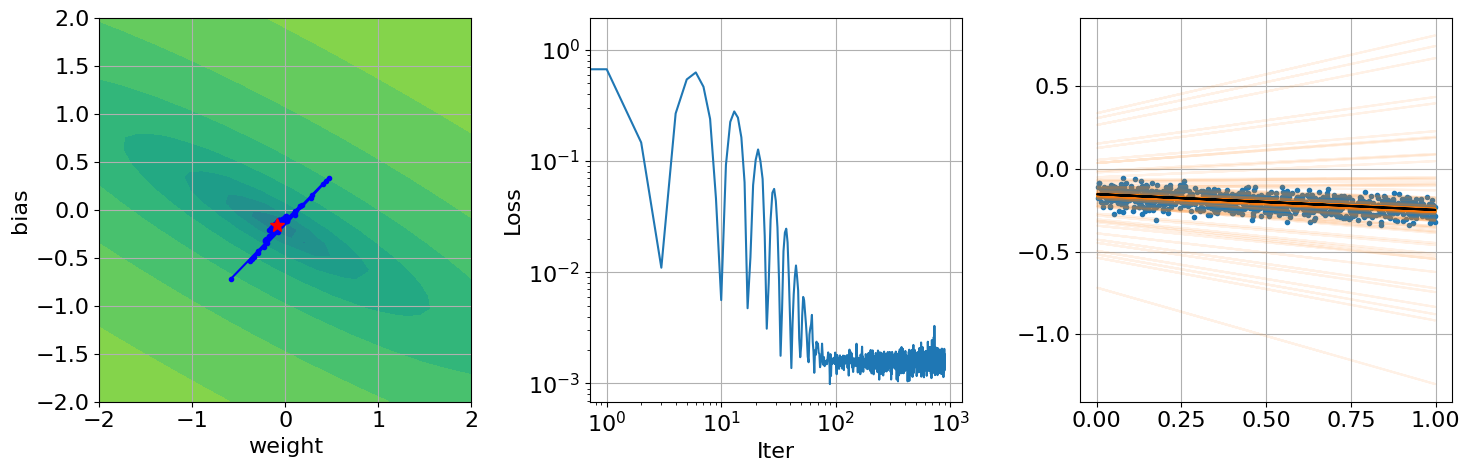

In [43]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()
    
    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    #ax.legend(['optim', '(A, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)   

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)